In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from ipywidgets import interact, interactive
from preprocessing import VandalismEncoder, RevisionGrouper, FeatureSelector
from plotting import plot_confusion_matrix, plot_scores, plot_precision_recall, plot_roc, plot_information_gain
from persistence import load_all_classifiers

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load classifiers
classifiers = load_all_classifiers('models-all-0c25f9f')

Loading model tag_1
Loading model tag_11
Loading model tag_12
Loading model tag_2
Loading model tag_3
Loading model tag_5
Loading model tag_6
Loading model tag_9


---
## Import Dataset

In [3]:
df = pd.read_csv('./data/features-0c25f9f.csv')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,...,hasNumericOutlierInColumns,hasNumericOutlierInRows,hasNumericOutlierInChangedCellValues,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,revision_id,tag_id
0,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,228189784,12
1,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,1.0,25.0,25.0,...,1.0,0.0,0.0,0.134129,0.0,0.0,0.0,0.0,730449352,12
2,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.0,7837.0,-1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,216224416,12
3,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.0,2108.0,-1.0,...,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,539338621,12
4,1.0,0.0,20.0,23.0,2.0,2.0,0.0,0.0,4077.0,-1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,746191686,12


---
## Preprocessing

In [4]:
def preprocessing(frame, features, tags):
    feature_columns = None
    selected_tags = []
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS
    
    if tags == 'all vandalism':
        selected_tags = [1, 2, 3, 5, 6, 9, 11]
    else:
        selected_tags.append(tags)

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder(selected_tags)),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tags:', selected_tags)
    return preprocess_pipeline.transform(frame)\
        .drop_duplicates()\
        .fillna(0)

In [5]:
processed_df = preprocessing(df, 'all', 'all vandalism')

Feature config: all Selected tags: [1, 2, 3, 5, 6, 9, 11]


In [6]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [7]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3720, 122)
y train (3720,)
X test (1240, 122)
y test (1240,)


In [8]:
estimators = [(str(tag_id), model['clf']) for tag_id, model in classifiers.items()]
vandalism_estimators = list(filter(lambda e: e[0] != '12', estimators))
vandalism_clf = VotingClassifier(vandalism_estimators, voting='soft')
no_vandalism_clf = list(filter(lambda e: e[0] == '12', estimators))[0][1]

In [9]:
clf = VotingClassifier([('0', no_vandalism_clf), ('1', vandalism_clf)], voting='soft', n_jobs=-1)
clf.fit(X_train, y_train)

VotingClassifier(estimators=[('0', BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split...se=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [10]:
y_test_predict = clf.predict(X_test)
y_test_predict_proba = clf.predict_proba(X_test)

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


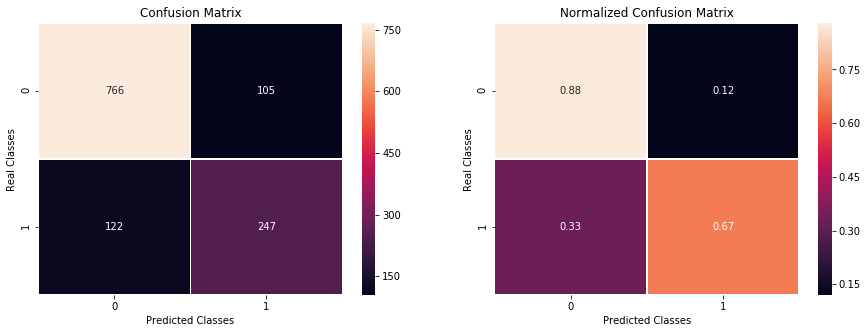

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.86      0.88      0.87       871
   Vandalism       0.70      0.67      0.69       369

 avg / total       0.81      0.82      0.82      1240



In [11]:
plot_confusion_matrix(y_test, y_test_predict)

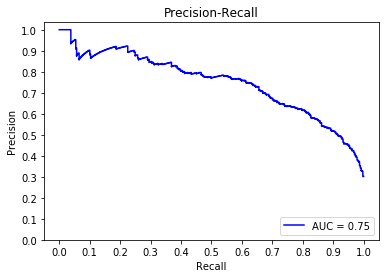

In [12]:
plot_precision_recall(y_test, y_test_predict_proba[:, 1])

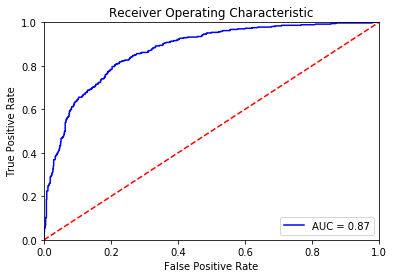

Receiver Operation Characteristic AUC 0.8720391164876058


In [13]:
plot_roc(y_test, y_test_predict_proba[:, 1])

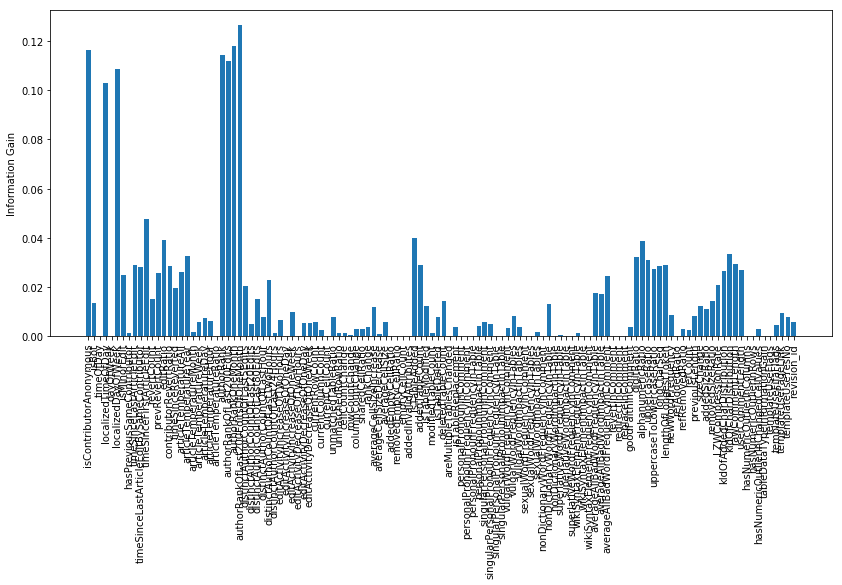

In [14]:
plot_information_gain(X, y)